## Importing Modules

In [318]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Reading Raw Files

In [320]:
robot_info = pd.read_csv("Raw Data/Robot_Info.csv")
priority_data = pd.read_excel("Raw Data/Management_Priority.xlsx",skiprows = 5)

## Data Pre Processing

In [322]:
# Transposing the information data for robots to make criterions as columns
robot_info = robot_info.set_index("Robot_Prototype").transpose().reset_index().rename(columns={'index': 'Robot_Prototype'})

In [324]:
# Creating Score column in the priority data using min max scoring and rank column created based on the business justification
max_score = 5
min_score = 1
max_rank = priority_data['Ranking'].max()
min_rank = priority_data['Ranking'].min()
priority_data['Score'] = max_score - ((priority_data['Ranking'] - min_rank) * (max_score - min_score) / (max_rank - min_rank))

## Data Analysis

In [326]:
# Creating weights out of the scores to calculate weighted sum
priority_data["Weight"]= priority_data["Score"]/priority_data["Score"].sum()
weights = priority_data.set_index('Feature')['Weight']
weights_dict = priority_data.set_index('Feature')['Weight'].to_dict()

Text(0.5, 1.0, 'Weights Distribution Across Criteria')

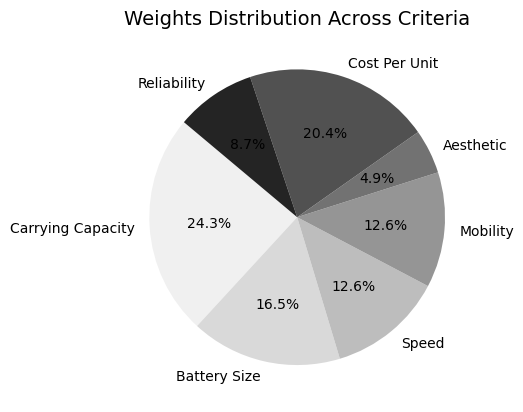

In [362]:
# Plot to show the weight distribution across the features

plt.subplot(1, 1, 1)  # Create a subplot for weights distribution

# Generate grey shades dynamically based on the number of slices
num_slices = len(weights_dict)
grey_shades = [plt.cm.Greys(i / (num_slices + 1)) for i in range(1, num_slices + 1)]
plt.pie(weights_dict.values(), labels=weights_dict.keys(), autopct='%1.1f%%', startangle=140, colors=grey_shades)
plt.title('Weights Distribution Across Criteria', fontsize=14)

In [332]:
# min max normalization of the criteria in information table to normalise the values for each robot
robot_normalized = robot_info.copy()
for column in weights.index:
    robot_normalized[column]= np.where(column == "Cost Per Unit", 
                                       (robot_info[column].max()-robot_info[column]) / (robot_info[column].max() - robot_info[column].min()),
                                       (robot_info[column] - robot_info[column].min()) / (robot_info[column].max() - robot_info[column].min()))

In [334]:
# Step 4: Calculate weighted scores for each robot
robot_normalized['Weighted_Score'] = robot_normalized[weights.index].mul(weights, axis=1).sum(axis=1)

# Step 5: Rank the robots based on their weighted scores
robot_normalized['Rank'] = robot_normalized['Weighted_Score'].rank(ascending=False)

# Step 6: Sort robots by rank
robot_ranking_table = robot_normalized[['Robot_Prototype', 'Weighted_Score', 'Rank'] + list(weights.index)].sort_values(by='Rank')

#

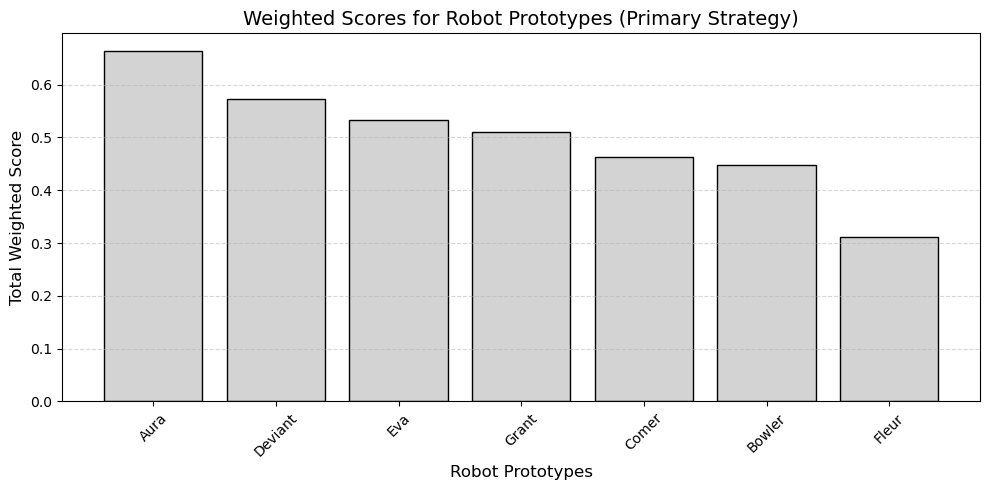

In [338]:
# Step 4: Create a bar chart for the total weighted scores
plt.figure(figsize=(10, 5))
plt.bar(robot_ranking_table['Robot_Prototype'], robot_ranking_table['Weighted_Score'], color='lightgrey', edgecolor='black')
plt.title('Weighted Scores for Robot Prototypes (Primary Strategy)', fontsize=14)
plt.xlabel('Robot Prototypes', fontsize=12)
plt.ylabel('Total Weighted Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Step 5: Save and display the bar chart
plt.savefig('weighted_scores_bar_chart.png', dpi=300)
plt.show()

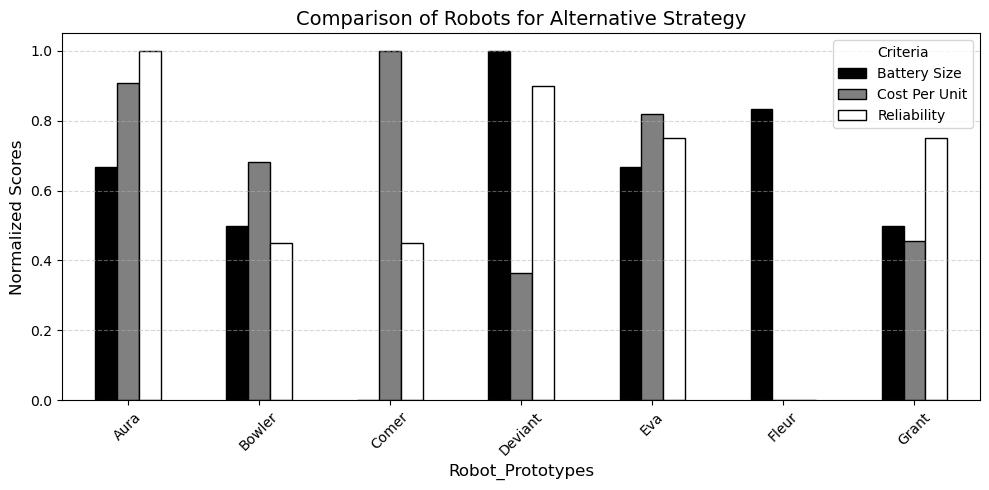

In [342]:
robot_data = robot_info.copy()

# Step 2: Select criteria for the Alternative Strategy
criteria = ['Battery Size', 'Cost Per Unit', 'Reliability']

# Normalize the values for comparison (Min-Max Normalization)
for criterion in criteria:
    robot_data[criterion + '_Normalized'] = np.where(criterion == "Cost Per Unit",
                                                     (robot_data[criterion].max() - robot_data[criterion]) / (robot_data[criterion].max() - robot_data[criterion].min()),
                                                    (robot_data[criterion] - robot_data[criterion].min()) / (robot_data[criterion].max() - robot_data[criterion].min()))

# Step 3: Prepare data for visualization
normalized_columns = [criterion + '_Normalized' for criterion in criteria]
comparison_data = robot_data[['Robot_Prototype'] + normalized_columns]

# Step 4: Create a grouped bar chart for comparison
comparison_data.set_index('Robot_Prototype', inplace=True)
comparison_data.plot(kind='bar', figsize=(10, 5), colormap='grey', edgecolor='black')

# Customizing the plot
plt.title('Comparison of Robots for Alternative Strategy', fontsize=14)
plt.ylabel('Normalized Scores', fontsize=12)
plt.xlabel('Robot_Prototypes', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(criteria, title='Criteria', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Step 5: Save and display the chart
plt.tight_layout()
plt.savefig('alternative_strategy_comparison_plot.png', dpi=300)
plt.show()

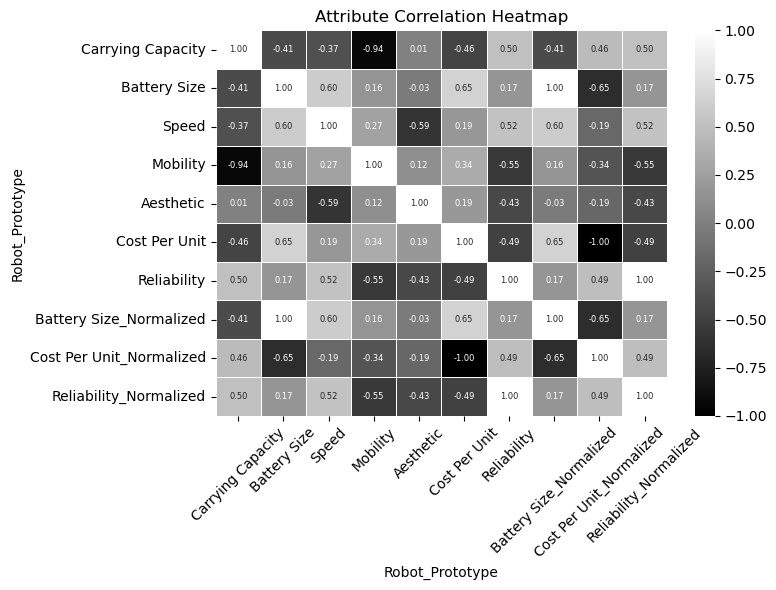

In [346]:
# Step 2: Select numerical columns for correlation analysis
numerical_columns = robot_data.select_dtypes(include=['float64', 'int64']).columns

# Step 3: Compute the correlation matrix
correlation_matrix = robot_data[numerical_columns].corr()

# Step 4: Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='grey', 
    fmt='.2f',  # Format as percentages
    annot_kws={"size": 6},  # Decrease font size
    linewidths=0.5
)

# Customizing the plot
plt.title('Attribute Correlation Heatmap', fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()

# Save and show the heatmap
plt.savefig('attribute_correlation_heatmap.png', dpi=300)
plt.show()

In [350]:
# Step 4: Alternative Strategy
# Focus on battery capacity, cost, and reliability
alt_factors = ['Battery Size_Normalized', 'Cost Per Unit_Normalized', 'Reliability_Normalized']
alt_weights = [1/3, 1/3, 1/3]  # Equal weights if not specified

# as cost per unit 
comparison_data['Alternative_Score'] = comparison_data[alt_factors].dot(alt_weights)

/var/folders/6_/lnnlyvg97bv1fbtwyqqth9z80000gn/T/ipykernel_4190/3355576774.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_data['Alternative_Score'] = comparison_data[alt_factors].dot(alt_weights)


In [352]:
# Step 5: Recommendations
alternative_recommendation = comparison_data.sort_values(by='Alternative_Score', ascending=False).iloc[0].reset_index()

print("\nRecommendation for Alternative Business Strategy:")
print(alternative_recommendation)


Recommendation for Alternative Business Strategy:
            Robot_Prototype      Aura
0   Battery Size_Normalized  0.666667
1  Cost Per Unit_Normalized  0.909091
2    Reliability_Normalized  1.000000
3         Alternative_Score  0.858586


In [290]:
comparison_data

Robot_Prototype,Battery Size_Normalized,Cost Per Unit_Normalized,Reliability_Normalized,Alternative_Score
Robot_Prototype,,,,
Aura,0.666667,0.090909,1.00,0.525253
Bowler,0.500000,0.318182,0.45,0.210606
Comer,0.000000,0.000000,0.45,0.150000
Deviant,1.000000,0.636364,0.90,0.421212
Eva,0.666667,0.181818,0.75,0.411616
Fleur,0.833333,1.000000,0.00,-0.055556
Grant,0.500000,0.545455,0.75,0.234848
